# 進化計算を行い最適な重み行列を見つける

In [ ]:
import numpy as np
import pprint
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import time

# from src.polynomial_sampler import  Polynomial_Sampler
load("/app/src/lib/sampler.sage")
load("/app/src/lib/buchberger.sage")
load("/app/src/lib/utils.sage")
load("/app/src/lib/differential_evolution.sage")

# これをしないと，sagemathが勝手にintやfloatをinteger型やRealNuber型に変換してしまうしてしまう
preparser(False)

## 環の定義

In [2]:
field =GF(32003)
# field = QQ

m_lex = matrix([[1,0,0], 
                [0,1,0], 
                [0,0,1]])

m_grlex = matrix([[1,1,1], 
                  [1,0,0], 
                  [0,1,0]])

m_grevlex = matrix([[1,1,1], 
                    [0,0,-1], 
                    [0,-1,0]])

T1 = TermOrder(m_lex)
T2 = TermOrder(m_grlex)
T3 = TermOrder(m_grevlex)


Ring_lex = PolynomialRing(field, 3, 'x', order=T1)
Ring_grlex = PolynomialRing(field, 3, 'x', order=T2)
Ring_grevlex = PolynomialRing(field, 3, 'x', order=T3)

## 多項式をサンプルする際の分布を調整

In [3]:
field = GF(32003)
# field = QQ
Ring = PolynomialRing(field, 3, 'x', order='lex')

conditions = {  'max_degree'      : 5, 
                'min_degree'      : 2,
                'max_num_terms'   : 10, 
                'max_coeff'       : 20,
                'num_bound'       : 20,
                'nonzero_instance': True,}

psampler = Polynomial_Sampler(Ring, 
                            degree_sampling='uniform', 
                            term_sampling='uniform', 
                            strictly_conditioned=True, 
                            conditions=conditions)


## 進化計算

### data内部の生成系が複数

#### 多項式系のサンプリング

In [4]:
data = []
for i in range(1000):
    set_random_seed(i) # seed値の設定
    F = psampler.sample(num_samples=3)
    data.append(F)

data

[[7986*x0^5 + 9350*x0^3*x1*x2 - 7436*x0 - 15389*x1,
  -5390*x0^2*x1^2 + 7157*x0^2*x1 + 12548*x0*x2 + 11913*x0 + 13103,
  6220*x0*x2 - 4407*x1 - 9314*x2 + 7507],
 [7451*x0^2*x1 - 87*x0*x1^2*x2 - 8057*x0*x1^2 - 9915*x0*x1 - 8480*x0*x2^2 + 14942*x1^2 - 9292*x2 - 5743,
  5135*x0^2*x1^2 + 12232*x0*x1 + 10792*x2^4 - 5992,
  -15693*x0^4*x1],
 [-11847*x0^3 - 11344*x0^2 - 6987*x0*x1 + 13994*x0*x2 + 10901*x1^2*x2 - 2702*x1^2 + 12109*x1*x2 + 4042*x2^2 - 13784*x2 - 7362,
  11975*x0^2*x2^2 + 3460*x0*x1^2*x2 - 6114*x1^3 + 8794*x1^2*x2^2 - 5566*x1 - 9129*x2^3 - 14303*x2 - 7120,
  -3367*x0*x1^2 - 8997*x1^2],
 [7179*x1^2 - 1029*x2^2,
  13311*x0 - 11177*x1*x2 - 11023*x2,
  8172*x0*x1 + 2539*x0 - 15354*x1^2*x2 - 12997*x1^2 - 1972*x1 + 7779*x2^2 + 12743*x2 - 12339],
 [-11194*x0^3*x1 - 1016*x0^2*x1^2 - 1639*x0*x1 - 12439*x0 - 12154*x1*x2 + 3812*x2^4,
  105*x0*x2 + 7314*x1^3*x2 - 1191*x1*x2^2 - 5482*x2 - 2659,
  -654*x0^2*x1^2 - 10687*x0*x1^2 - 2023*x0*x2 + 14788*x1^3*x2 + 2526*x1^2*x2 + 4614*x1^2 - 6360*x2

#### 進化計算の実行

In [ ]:
bounds = [(-100000000, 100000000)] * 9

# differential_evolution の実行
try:
    result = differential_evolution(output_additions, bounds, popsize=30, disp=True, workers=-1, args=(data, field, 3, 'normal', True, 100000))
    pprint.pprint(result)
except Exception as e:
    print(f"An error occurred: {e}")

#### 分析

##### original, grevlex, grlex

In [10]:
result.x

array([ 68852442.82396656,  78444067.25030395,  77237283.42514442,
        -9246874.30177589, -54039264.08116665, -31147204.50709305,
        19566779.90130027,  17357043.63414998, -27674219.89811132])

In [13]:
# params = result.x
# params = np.array([ 87755247.02718942,  88624994.52227058,  88543018.71615866,
#                     39838971.61448123, -57905937.70052167,  20461411.90315791,
#                     86538359.61808026, -10068745.59245083, -56687631.77644371])

params = np.array([693, 745, 745, -167, 801, -40, 891, 248, 95])
# params = np.array([693.8243778776354, 745.589851484854, 745.8681148040818, -167.4968875848186, 801.0734115894567, -40.62988075988816, 891.1854523146767, 248.7716713118564, 95.81565958457783])


weight_matrix = matrix(3, list(params)) # paramsがnp.ndarrayの場合うまくいかない
T = TermOrder(weight_matrix)
Ring_weight_matrix = PolynomialRing(GF(32003), 3, 'x', order=T)

# Ring_list = [Ring_weight_matrix, Ring_grevlex, Ring_grlex, Ring_lex]
Ring_list = [Ring_weight_matrix, Ring_grevlex, Ring_grlex]


##### poly_add 出力 

In [16]:
all_additions = np.zeros((0, len(Ring_list)))
threshold = 100000 # 閾値

for polynomial_list in data:
    each_additions = np.array([])
    for Ring in Ring_list:
        GB, stats = buchberger(Ring, polynomial_list, select_strategy='normal', stop_algorithm=True, threshold=threshold)

        if not GB: # buchberger algorithmが途中で打ち切られた場合
            each_additions = np.append(each_additions, threshold)
            continue

        if is_groebner(Ring, GB): # buchberger algorithmが正常に終了した場合
            each_additions = np.append(each_additions, stats['polynomial_additions'])
        else:
            each_additions = np.append(each_additions, np.nan)

    all_additions = np.vstack([all_additions, each_additions])


##### ヒストグラム

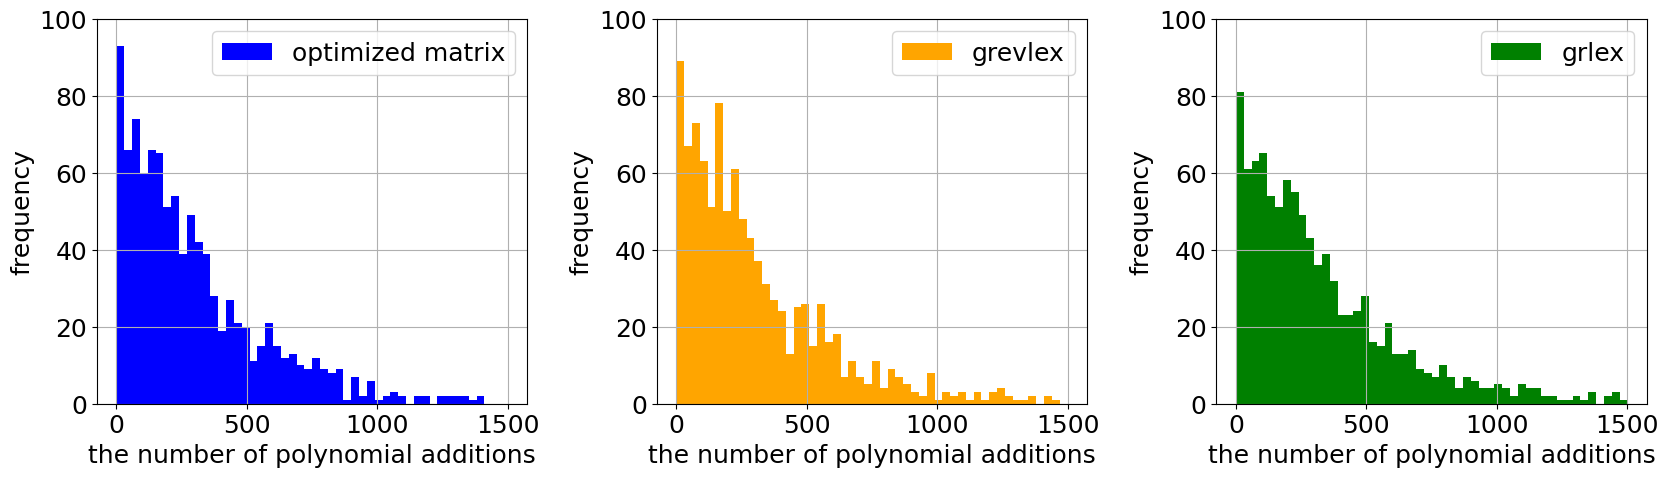

In [17]:
fig = plt.figure(figsize=(20, 5))

plt.rcParams['font.size'] = 18
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
# ax4 = fig.add_subplot(2, 2, 4)

# Ensure all_additions is a NumPy array with the correct data type
all_additions = np.array(all_additions, dtype=float)


x = (0, 1500)
bins = 50
ax1.hist(all_additions[:, 0], range=x, bins=bins, label='optimized matrix', color='blue')
ax2.hist(all_additions[:, 1], range=x, bins=bins, label='grevlex', color='orange')
ax3.hist(all_additions[:, 2], range=x, bins=bins, label='grlex', color='green')
# ax4.hist(all_additions[:, 3], range=(float(0), float(10000)), bins=bins, label='lex', color='red')

upper = 100
ax1.set_ylim(0, upper)
ax2.set_ylim(0, upper)
ax3.set_ylim(0, upper)
# ax4.set_ylim(0, 100)

ax1.set_xlabel('the number of polynomial additions')
ax2.set_xlabel('the number of polynomial additions')
ax3.set_xlabel('the number of polynomial additions')
# ax4.set_xlabel('the number of polynomial additions')

ax1.set_ylabel('frequency')
ax2.set_ylabel('frequency')
ax3.set_ylabel('frequency')
# ax4.set_ylabel('frequency')

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# ax4.grid(True)

ax1.legend()
ax2.legend()
ax3.legend()

fig.show()

##### 標準偏差など

In [18]:
print('mean: ', all_additions.mean(axis=0))
print('max: ', all_additions.max(axis=0))
print('min: ', all_additions.min(axis=0))
print('std: ', all_additions.std(axis=0))
print('median: ', np.median(all_additions, axis=0))

print('coeff: ', np.corrcoef(all_additions[:, 0], all_additions[:, 1])[0, 1]) # optimized and grevlex

mean:  [302.609 314.415 344.603]
max:  [1659. 2545. 2597.]
min:  [0. 0. 0.]
std:  [278.4136062  309.89084978 333.76467966]
median:  [220.  220.5 247. ]
coeff:  0.8209995786085231


In [19]:
num = all_additions[:, 0] <= all_additions[:, 1]
sum(num) / len(num)

0.524

##### optとgrevlex比較

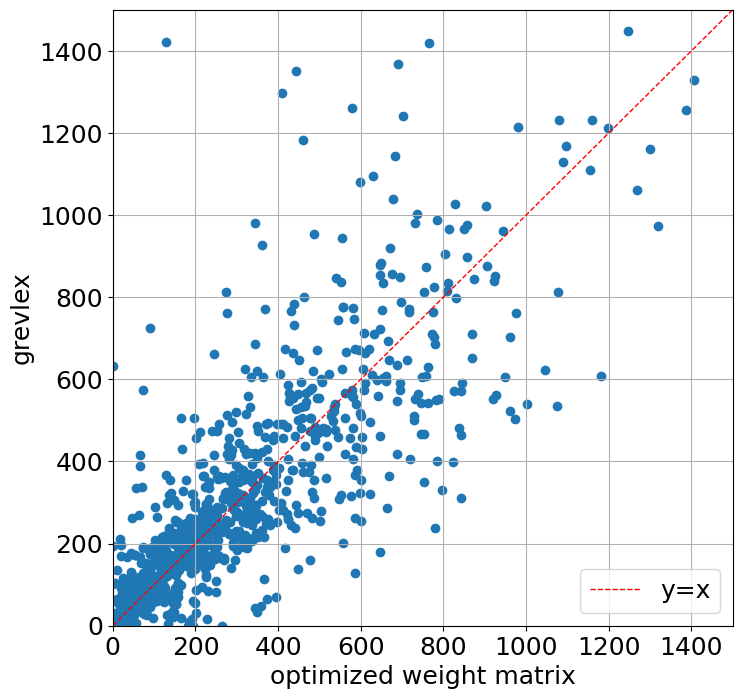

In [20]:
x = all_additions[:, 0]
y = all_additions[:, 1]


fig = plt.figure(figsize=(8, 8))

plt.rcParams['font.size'] = 18
# plt.tight_layout()

ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)

upper = 1500
ax.set_xlim(0, upper)
ax.set_ylim(0, upper)

ax.set_xlabel('optimized weight matrix')
ax.set_ylabel('grevlex')
ax.grid(True)

ax.plot([0, upper], [0, upper], color='red', linestyle='--', linewidth=1, label='y=x')
ax.legend()

fig.show()



##### lex

In [ ]:
threshold = 100000
lex_additions = np.array([])

for i, polynomial_list in enumerate(data):
    GB, stats = buchberger(Ring_lex, polynomial_list, select_strategy='normal', stop_algorithm=True, threshold=threshold)

    
    if not GB: # buchberger algorithmが途中で打ち切られた場合
        print(i)
        lex_additions = np.append(lex_additions, threshold)
        continue

    if is_groebner(Ring_lex, GB): # buchberger algorithmが正常に終了した場合
        lex_additions = np.append(lex_additions, stats['polynomial_additions'])
    else:
        lex_additions = np.append(lex_additions, np.nan)

lex_additions

NameError: name 'lex_additions' is not defined

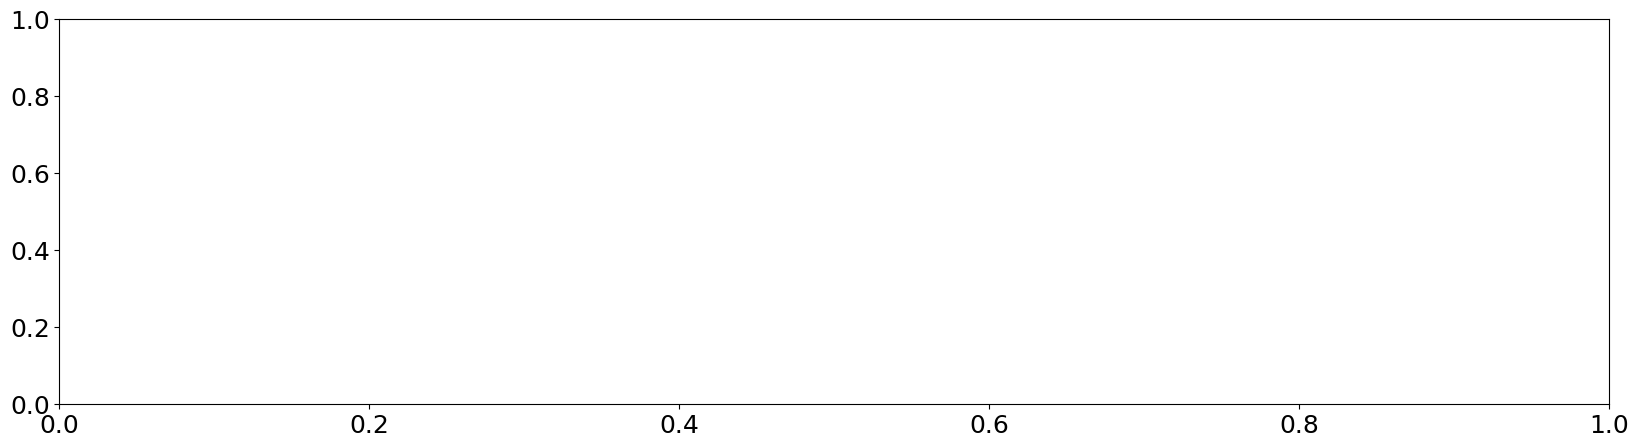

In [12]:
fig = plt.figure(figsize=(20, 5))
plt.rcParams['font.size'] = 18
plt.tight_layout()
ax1 = fig.add_subplot(1, 1, 1)

x = (float(0), float(100000))
bins = 100
ax1.hist(lex_additions, range= x, bins=bins, label='lex', color='red')


upper = 400
ax1.set_ylim(0, upper)


ax1.set_xlabel('the number of polynomial additions')


ax1.set_ylabel('frequency')

ax1.grid(True)


ax1.legend()


fig.show()

In [15]:
params

array([ 87755247.02718942,  88624994.52227058,  88543018.71615866,
        39838971.61448123, -57905937.70052167,  20461411.90315791,
        86538359.61808026, -10068745.59245083, -56687631.77644371])

## 他の分布での実験(10000サンプル)

In [21]:
data2 = []
for i in range(10000):

    F = psampler.sample(num_samples=3)
    data2.append(F)

data2

[[-7666*x0^2*x1^2*x2 + 626*x0*x1 + 9721*x0,
  3378*x0^2 + 15672*x0*x1 - 7430*x0*x2^2 - 5828*x1^2 - 6199*x1 + 3876*x2 - 3211,
  -14273*x0^2 + 15684*x0*x1^3],
 [-5533*x0^3*x2^2 - 2718*x0*x1*x2 + 9603*x1^2*x2^2 + 2822*x2^5 - 10992*x2,
  -14489*x0^2 + 2907*x0*x1 - 2420*x0*x2 + 1578*x1^2*x2 - 13836*x1^2 - 3581*x1*x2 - 13515*x1 - 14207*x2^2 + 10075*x2 + 8641,
  -9608*x0^5 - 11480*x0^2*x2^2 + 5934*x0*x2 + 13293*x0 - 7514*x1^5 + 12866*x1^4*x2 - 11156*x1*x2^2 + 8808*x2 - 13050],
 [7655*x0^4*x2 - 7290*x0^2*x1*x2^2 + 954*x0*x1^3*x2 + 5646*x0*x1^2*x2 + 8688*x1^3 - 14657*x2 - 9786,
  9497*x0^2 - 10999*x0*x1^2*x2 + 11920*x0*x1 + 5776*x0*x2 - 971*x0 - 2051*x1*x2 + 10651*x1 + 5101,
  -8490*x0^2 - 11862*x0*x1 + 2362*x0*x2 - 2358*x0 + 13626*x1*x2 - 2107*x1 + 4015*x2^2 - 4577*x2 - 13306],
 [517*x0^2*x1*x2 - 2484*x0,
  7040*x0*x1,
  -14564*x0*x1^2*x2^2 + 13420*x0*x1^2*x2 - 9038*x0*x1^2 - 1743*x0*x2 + 9983*x1^5 - 15793*x1^2*x2^3 + 124*x1^2 - 10393*x2^4 + 5768*x2^2 + 6112],
 [-14170*x0^2 + 12657*x0*x1^2 - 3

In [22]:
all_additions = np.zeros((0, len(Ring_list)))
threshold = 100000

for polynomial_list in data2:
    each_additions = np.array([])
    for Ring in Ring_list:
        GB, stats = buchberger(Ring, polynomial_list, select_strategy='normal', stop_algorithm=True, threshold=threshold)

        if not GB: # buchberger algorithmが途中で打ち切られた場合
            each_additions = np.append(each_additions, threshold)
            continue

        if is_groebner(Ring, GB): # buchberger algorithmが正常に終了した場合
            each_additions = np.append(each_additions, stats['polynomial_additions'])
        else:
            each_additions = np.append(each_additions, np.nan)

    all_additions = np.vstack([all_additions, each_additions])
           


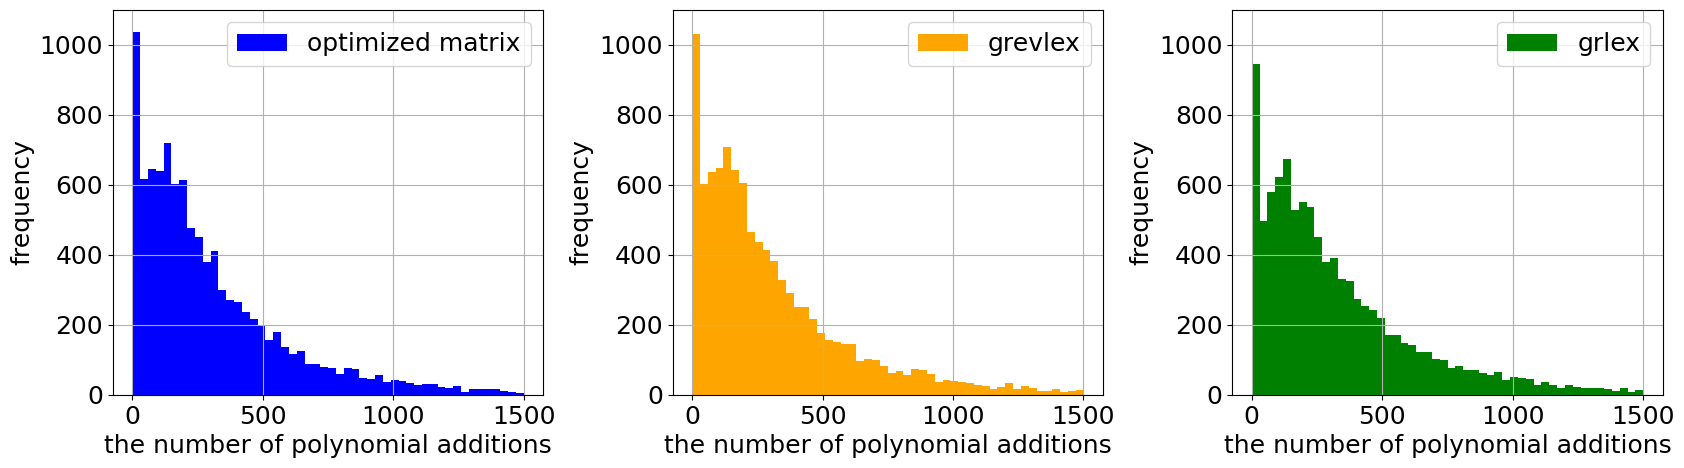

In [23]:
fig = plt.figure(figsize=(20, 5))

plt.rcParams['font.size'] = 18
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)


ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
# ax4 = fig.add_subplot(2, 2, 4)

# Ensure all_additions is a NumPy array with the correct data type
all_additions = np.array(all_additions, dtype=float)

x = (float(0), float(1500))
bins = 50
ax1.hist(all_additions[:, 0], range= x, bins=bins, label='optimized matrix', color='blue')
ax2.hist(all_additions[:, 1], range= x, bins=bins, label='grevlex', color='orange')
ax3.hist(all_additions[:, 2], range= x, bins=bins, label='grlex', color='green')
# ax4.hist(all_additions[:, 3], range=(float(0), float(10000)), bins=bins, label='lex', color='red')

upper = 1100
ax1.set_ylim(0, upper)
ax2.set_ylim(0, upper)
ax3.set_ylim(0, upper)
# ax4.set_ylim(0, 100)

ax1.set_xlabel('the number of polynomial additions')
ax2.set_xlabel('the number of polynomial additions')
ax3.set_xlabel('the number of polynomial additions')
# ax4.set_xlabel('the number of polynomial additions')

ax1.set_ylabel('frequency')
ax2.set_ylabel('frequency')
ax3.set_ylabel('frequency')
# ax4.set_ylabel('frequency')

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# ax4.grid(True)

ax1.legend()
ax2.legend()
ax3.legend()

fig.show()

In [24]:
print('mean: ', all_additions.mean(axis=0))
print('max: ', all_additions.max(axis=0))
print('min: ', all_additions.min(axis=0))
print('std: ', all_additions.std(axis=0))
print('median: ', np.median(all_additions, axis=0))

print('coeff: ', np.corrcoef(all_additions[:, 0], all_additions[:, 1])[0, 1]) # optimized and grevlex

num = all_additions[:, 0] <= all_additions[:, 1]
sum(num) / len(num)

mean:  [319.1243 320.3369 352.8757]
max:  [4650. 5138. 5110.]
min:  [0. 0. 0.]
std:  [330.50055015 336.67065093 366.80615814]
median:  [218. 218. 243.]
coeff:  0.8429413257106793


0.516

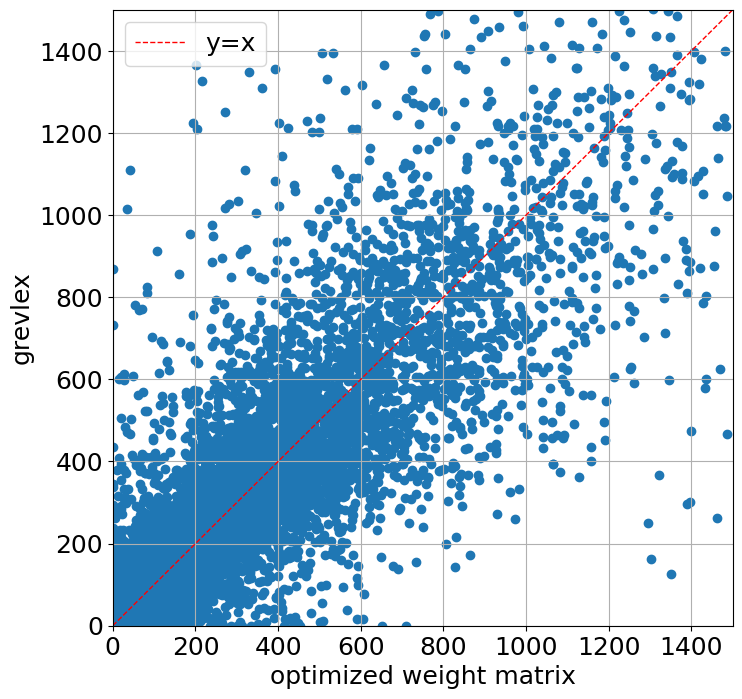

In [41]:
x = all_additions[:, 0]
y = all_additions[:, 1]


fig = plt.figure(figsize=(8, 8))

plt.rcParams['font.size'] = 18
# plt.tight_layout()

ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)

upper = 1500
ax.set_xlim(0, upper)
ax.set_ylim(0, upper)

ax.set_xlabel('optimized weight matrix')
ax.set_ylabel('grevlex')
ax.grid(True)

ax.plot([0, upper], [0, upper], color='red', linestyle='--', linewidth=1, label='y=x')
ax.legend()

fig.show()